__This notebook show the model evaludation results of the models using Morgan2 fingerprint__
- Use the my-rdkit-env environment

In [20]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# 1. Import data

In [21]:
train_test_path = "../../data_for_modeling/train_test_data/new_HDAC2_train_test_data.xlsx"
train_dataset = pd.read_excel(train_test_path, sheet_name='train_dataset')
test_dataset = pd.read_excel(train_test_path, sheet_name='test_dataset')
validation_dataset = pd.read_excel(train_test_path, sheet_name='validation_dataset')

In [22]:
print(len(train_dataset), len(test_dataset), len(validation_dataset))

1966 421 422


In [23]:
train_dataset.head()

,CID,SMILES,Categories,ZBG Classified,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,71465855,Nc1ccc(cc1NC(=O)N1CCOCC1)-c1cccs1,active,21,NaN,NaN,NaN
1,5281220,O=C1/C(=C/c2ccc(O)c(O)c2)Oc2cc(O)cc(O)c21,inactive,5,NaN,NaN,NaN
2,162654159,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(C)CC2)c1...,inactive,5,15.0,NaN,NaN
3,44571332,O=C(NO)c1ccc(CN2C(=O)CNC(=O)[C@H]2Cc2cccs2)cc1,inactive,1,15.0,NaN,NaN
4,130361881,O=C(NO)c1ccc(CN2CCCc3ccccc32)cc1,inactive,1,15.0,NaN,NaN


# 2. Model training with Morgan2 fingerprint

## Morgan2 fingerprint encoding

In [24]:
#MACCS
from tqdm import tqdm

def ecfp4_fpts(data):
    Morgan_fpts = []
    count = 0
    with tqdm(total=len(data), desc='Progress') as pbar:
        for i in data:
            try:
                mol = Chem.MolFromSmiles(i)
                fpts = AllChem.GetMorganFingerprintAsBitVect(mol=mol, radius=2, nBits=1024)
            except:
                print("An exception occurred with " + str(count))
                continue
            mfpts = np.array(fpts)
            Morgan_fpts.append(mfpts)
            count += 1
            pbar.update(1)  # Update the progress bar
    return np.array(Morgan_fpts)

In [25]:
#X data
X_Train = ecfp4_fpts(train_dataset['SMILES'])
X_Test = ecfp4_fpts(test_dataset['SMILES'])
X_Validation = ecfp4_fpts(validation_dataset['SMILES'])

Progress: 100%|██████████| 422/422 [00:00<00:00, 3095.52it/s]


In [26]:
#y data
y_Train = np.array(train_dataset['Categories'])
y_Test = np.array(test_dataset['Categories'])
y_Validation = np.array(validation_dataset['Categories'])

#Original data
print("Original data:")
print(y_Train[0:5])
print(y_Test[0:5])
print(y_Validation[0:5])

#One-hot encoder
import sklearn.preprocessing as preprocessing
label_encoder = preprocessing.LabelEncoder()
y_Train = label_encoder.fit_transform(y_Train)
y_Test = label_encoder.fit_transform(y_Test)
y_Validation = label_encoder.fit_transform(y_Validation)
print("Encoded data:")
print(y_Train[0:5])
print(y_Test[0:5])
print(y_Validation[0:5])

Original data:
['active' 'inactive' 'inactive' 'inactive' 'inactive']
['active' 'inactive' 'inactive' 'active' 'active']
['inactive' 'active' 'inactive' 'active' 'inactive']
Encoded data:
[0 1 1 1 1]
[0 1 1 0 0]
[1 0 1 0 1]


## Model training

__Random Forest Classifier__

In [27]:
rf_morgan2 = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
rf_morgan2.fit(X_Train, y_Train)

RandomForestClassifier(criterion='entropy', random_state=42)

__K Nearest Neighbor__

In [28]:
knn_morgan2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_morgan2.fit(X_Train, y_Train)

KNeighborsClassifier()

__SVM__

In [29]:
svm_morgan2 = SVC(kernel='rbf', random_state=42, probability=True)
svm_morgan2.fit(X_Train, y_Train)

SVC(probability=True, random_state=42)

__XGBoost__

In [30]:
# bst_morgan2 = XGBClassifier(objective='binary:logistic', tree_method="hist")
bst_morgan2 = XGBClassifier(objective='binary:logistic', tree_method = "hist", device = "cuda")
bst_morgan2.fit(X_Train, y_Train)

[09:17:03] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "device" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [31]:
#sklearn models -> use joblib
dump(rf_morgan2, "../../results/models/rf_ecfp4.joblib")
dump(svm_morgan2, "../../results/models/svm_ecfp4.joblib")
dump(knn_morgan2, "../../results/models/knn_ecfp4.joblib")
#Xgboost
bst_morgan2.save_model("../../results/models/xgboost_ecfp4.json")

# Reload models

In [32]:
bst_morgan2 = XGBClassifier(objective='binary:logistic', tree_method = "hist", device = "cuda:0")
bst_morgan2.load_model("../../results/models/xgboost_ecfp4.json")

In [33]:
rf_morgan2 = load("../../results/models/rf_ecfp4.joblib")
svm_morgan2 = load("../../results/models/svm_ecfp4.joblib")
knn_morgan2 = load("../../results/models/knn_ecfp4.joblib")

# Model evaluation

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
import math

def model_evaluation_calculation(cm):
    tp = cm[0][0]; tn = cm[1][1]; fp = cm[0][1]; fn = cm[1][0]
    ac = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    precision = tp / (tp +fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return ac, precision, recall, mcc, f1

def me_result(cm, model_name):
    cm_string = "Confusion matrix of " + model_name
    print(cm_string)
    print(cm)
    ac, se, sp, mcc, f1 = model_evaluation_calculation(cm)
    print("Comparision:")
    table = [['Model', 'AC', 'SE', 'SP', 'MCC', 'F1'], [model_name, ac, se, sp, mcc, f1]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

### 1. Calculate all the evaluation metrics on test and validation dataset

In [36]:
X_Total = np.concatenate((X_Train, X_Validation), axis=0)
y_Total = np.concatenate((y_Train, y_Validation), axis=0)

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

cols = ['Model', 'Fingerprint', 'Test-set Accuracy', 'Test-set Precision', 'Test-set Recall', 'Test-set MCC', 'Test-set F1', 'Test-set AUC', 
        'Training error', 'Test error', 'Validation error',
        'Validation-set Accuracy', 'Validation-set Precision', 'Validation-set Recall', 'Validation-set MCC', 'Validation-set F1', 'Validation-set AUC']

model_result = pd.DataFrame(columns=cols)
# cv = KFold(n_splits=5, random_state=1, shuffle=True)

for model_name in ['KNN', 'RF', 'SVM', 'XgBoost']:
    cv_scores = None
    y_pred_test = None
    y_pred_train = None
    y_pred_validation = None
    model = None
    
    if model_name == 'KNN':
        model = knn_morgan2
    elif model_name == 'RF':
        model = rf_morgan2
    elif model_name == 'SVM':
        model = svm_morgan2
    elif model_name == 'XgBoost':
        model = bst_morgan2
    else:
        print("Error")
    
    
    #Cross validation
    # cv_scores = cross_val_score(model, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
    
    #Test set
    y_pred_test = model.predict(X_Test)
    y_proba_test = model.predict_proba(X_Test)[:, 1]
    auc_score_test = roc_auc_score(y_Test, y_proba_test)
    cm_test = confusion_matrix(y_Test, y_pred_test)
    test_ac, test_precision, test_recall, test_mcc, test_f1 = model_evaluation_calculation(cm_test)
    test_error = 1 - test_ac
    
    #validation set
    y_pred_validation = model.predict(X_Validation)
    y_proba_validation = model.predict_proba(X_Validation)[:, 1]
    auc_score_validation = roc_auc_score(y_Validation, y_proba_validation)
    cm_validation = confusion_matrix(y_Validation, y_pred_validation)
    validation_ac, validation_precision, validation_recall, validation_mcc, validation_f1 = model_evaluation_calculation(cm_validation)
    validation_error = 1 - validation_ac
    
    #train set
    y_pred_train = model.predict(X_Train)
    y_proba_train = model.predict_proba(X_Train)[:, 1]
    auc_score_train = roc_auc_score(y_Train, y_proba_train)
    cm_train = confusion_matrix(y_Train, y_pred_train)
    train_ac, _, _, _, _ = model_evaluation_calculation(cm_train)
    train_error = 1 - train_ac
    
    row_result = pd.DataFrame([[model_name, "ECFP4 (1024 bits)", 
                                test_ac*100, test_precision*100, test_recall*100, test_mcc*100, test_f1*100, auc_score_test*100, 
                                train_error*100, test_error*100, validation_error*100,
                                validation_ac*100, validation_precision*100, validation_recall*100, validation_mcc*100, validation_f1*100, auc_score_validation*100]], 
                                columns=cols)
    
    model_result = pd.concat([model_result, row_result], ignore_index=True)

In [38]:
model_result.head()

,Model,Fingerprint,Test-set Accuracy,Test-set Precision,Test-set Recall,Test-set MCC,Test-set F1,Test-set AUC,Training error,Test error,Validation error,Validation-set Accuracy,Validation-set Precision,Validation-set Recall,Validation-set MCC,Validation-set F1,Validation-set AUC
0,KNN,ECFP4 (1024 bits),85.035629,66.423358,84.259259,64.839773,74.285714,88.389277,10.630722,14.964371,16.113744,83.886256,64.285714,77.884615,60.016138,70.434783,88.101941
1,RF,ECFP4 (1024 bits),84.323040,64.963504,83.177570,63.088343,72.950820,89.087077,0.457782,15.676960,14.218009,85.781991,66.666667,82.352941,64.762762,73.684211,90.669241
2,SVM,ECFP4 (1024 bits),85.035629,62.773723,87.755102,64.911249,73.191489,88.678421,9.104781,14.964371,14.454976,85.545024,61.111111,86.516854,64.006396,71.627907,89.808559
3,XgBoost,ECFP4 (1024 bits),85.273159,68.613139,83.185841,65.472187,75.200000,91.102087,1.831129,14.726841,14.454976,85.545024,66.666667,81.553398,64.188613,73.362445,90.489597


Save the Model results

In [39]:
model_result.to_excel('../../results/model_results/20240301_ecfp4_model_result.xlsx')

### 2. ROC Curves

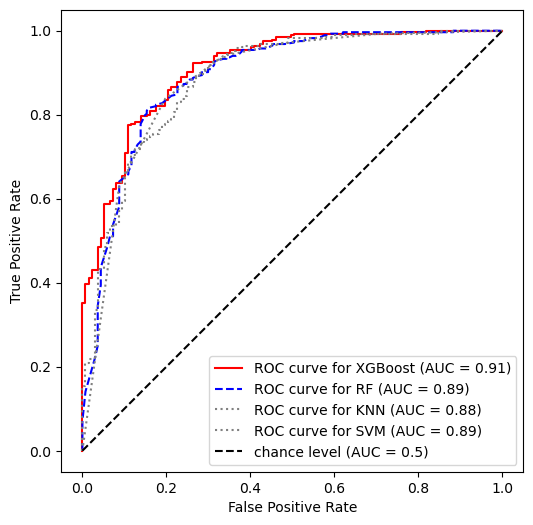

In [40]:
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_estimator(
    estimator=bst_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for XGBoost",
    color='red',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=rf_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for RF",
    color='blue',
    linestyle="dashed",
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=knn_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for KNN",
    color='gray',
    linestyle='dotted',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=svm_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for SVM",
    color='gray',
    linestyle='dotted',
    ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("ECFP4 (2048 bits) fingerprint models ROC curves")
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import roc_auc_score
knn_y_proba = knn_morgan2.predict_proba(X_Test)[:, 1]
rf_y_proba = rf_morgan2.predict_proba(X_Test)[:, 1]
svm_y_proba = svm_morgan2.predict_proba(X_Test)[:, 1]
bst_y_proba = bst_morgan2.predict_proba(X_Test)[:, 1]

knn_auc_score = roc_auc_score(y_Test, knn_y_proba)
rf_auc_score = roc_auc_score(y_Test, rf_y_proba)
svm_auc_score = roc_auc_score(y_Test, svm_y_proba)
bst_auc_score = roc_auc_score(y_Test, bst_y_proba)
print(knn_auc_score, rf_auc_score, svm_auc_score, bst_auc_score)

0.8838927726945615 0.8908707720777217 0.8867842089030533 0.9110208697440115
